# 🧨 Fast Stable Diffusion in free Colab with JAX / Flax on TPU!

🤗 Hugging Face [Diffusers](https://github.com/huggingface/diffusers) supports Flax since version `0.5.1`! This allows for snappy inference on Google TPUs, such as those available in Colab, Kaggle or through Google Cloud Platform.

If you want more details about how Stable Diffusion works using JAX please refer to [our blog](https://huggingface.co/blog/stable_diffusion_jax) or [this Colab notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).

## Initial Steps

In [3]:
#@title Install required libraries
!pip install huggingface_hub==0.10.0 gradio

In [ ]:
#@title Login to the Hugging Face Hub
#@markdown Make sure you also have read and accept the LICENSE of the [Stable Diffusion model](https://huggingface.co/CompVis/stable-diffusion-v1-4), otherwise you may find an error
from huggingface_hub import notebook_login
!git config --global credential.helper store

notebook_login()

## Setup
Run all cells for setting up JAX and the model

In [ ]:
#@title Set up JAX
#@markdown If you see an error, make sure you are using a TPU backend. Select `Runtime` in the menu above, then select the option "Change runtime type" and then select `TPU` under the `Hardware accelerator` setting.
!pip install --upgrade jax jaxlib 

import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu('tpu_driver_20221011')

!pip install flax diffusers transformers ftfy
jax.devices()



In [6]:
#@title Import required libraries
import numpy as np
import jax
import jax.numpy as jnp

from pathlib import Path
from jax import pmap
from flax.jax_utils import replicate
from flax.training.common_utils import shard
from PIL import Image

from huggingface_hub import notebook_login
from diffusers import FlaxStableDiffusionPipeline
import torch
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [ ]:
#@title Load the model
#@markdown It's safe to ignore the warning messages, everything is okay
pipeline, params = FlaxStableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="bf16", dtype=jnp.bfloat16)
p_params = replicate(params)

## Run!

Seed used 729606234


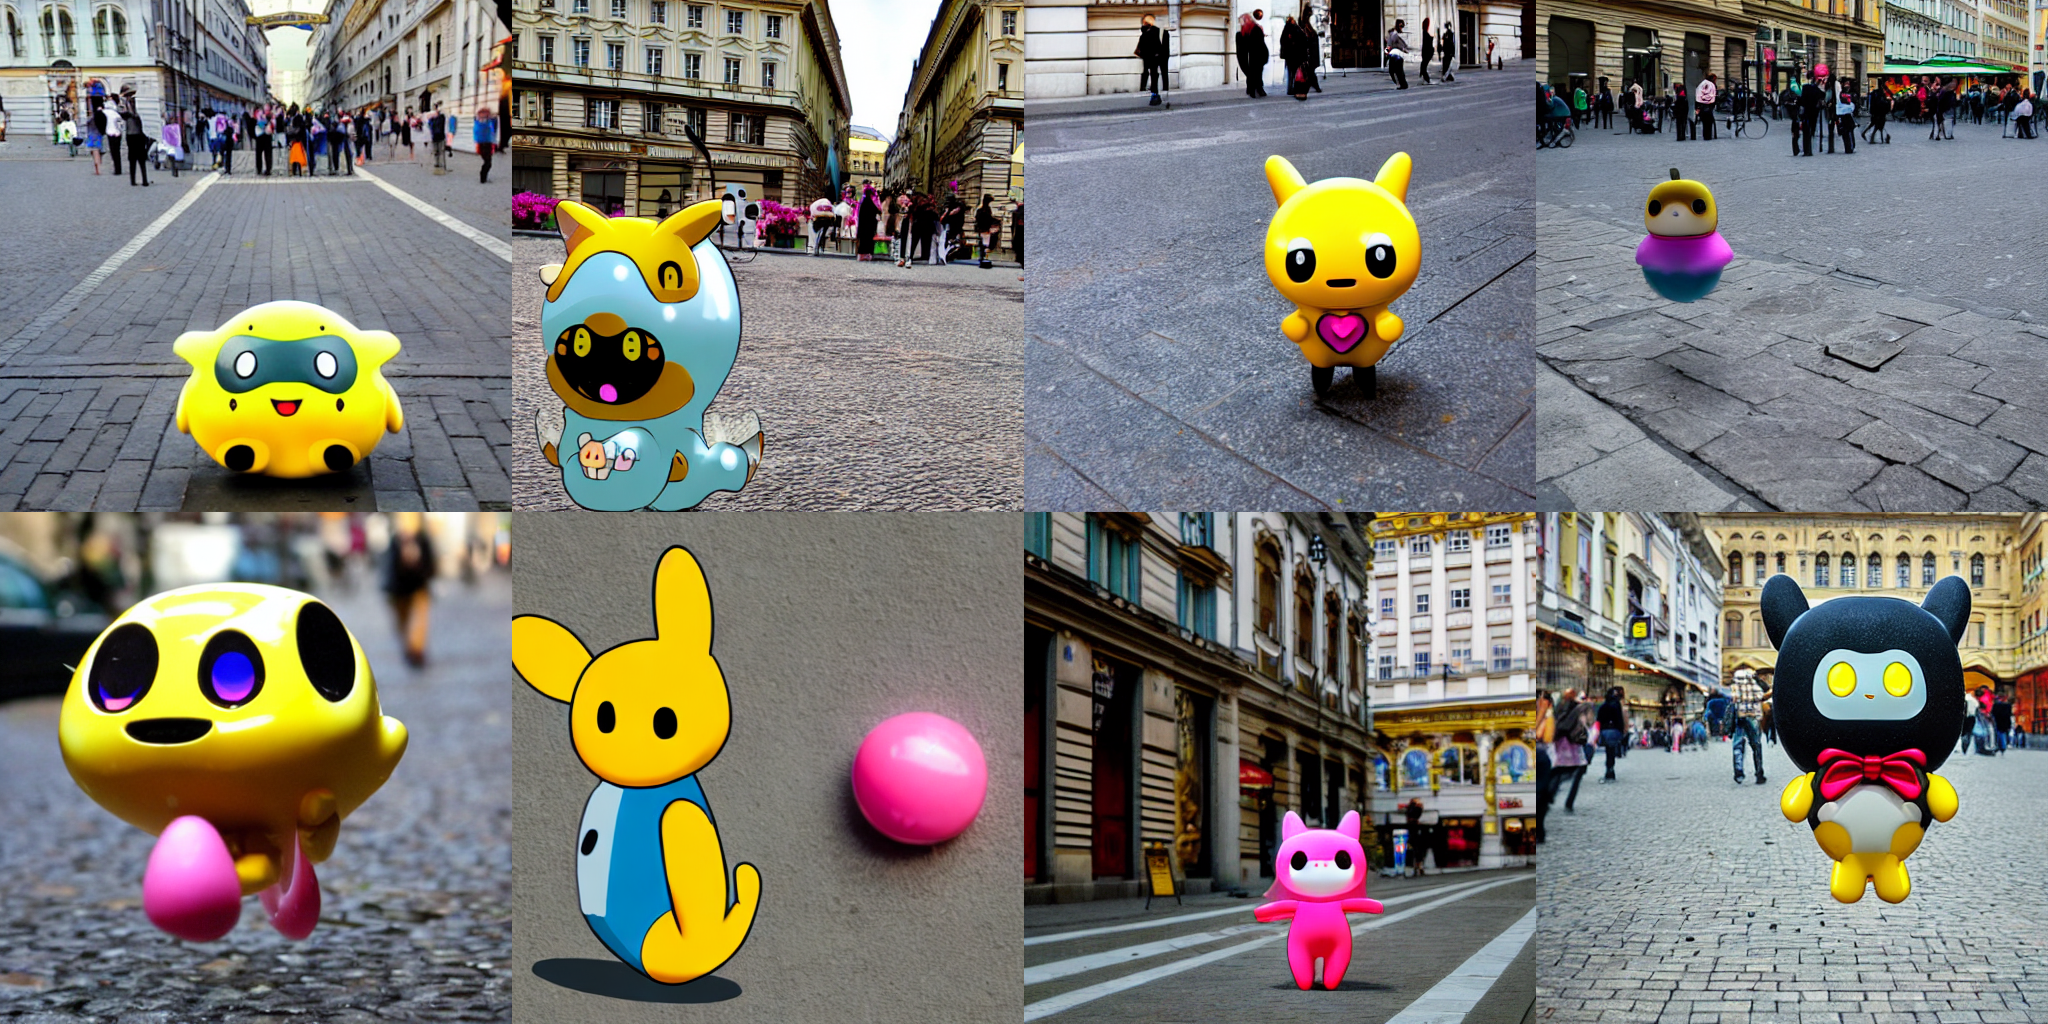

In [8]:
#@title Set and go!
#@markdown First run takes ~50s as it compiles stuff. Then, it should take around ~8s per prompt!
prompt = "the spirit of a tamagotchi wandering in the city of Vienna" #@param {type:"string"}
num_inference_steps = 50 #@param {type:"integer"}
seed = -1 #@param {type:"integer"}
#@markdown `-1` will set a random seed. You can replace that to any integer for reproducible results

if(seed == -1):
  import random
  random_int = random.randint(0, 2147483647)
  real_seed = random_int
else:
  real_seed = seed
prng_seed = jax.random.PRNGKey(real_seed)
prng_seed = jax.random.split(prng_seed, jax.device_count())
num_samples = jax.device_count()
prompt = num_samples * [prompt]
prompt_ids = pipeline.prepare_inputs(prompt)
prompt_ids = shard(prompt_ids)
images = pipeline(prompt_ids, p_params, prng_seed, num_inference_steps, jit=True).images
images_pil = pipeline.numpy_to_pil(np.asarray(images.reshape((num_samples,) + images.shape[-3:])))
if(seed == -1):
  print(f"Seed used {real_seed}")
image_grid(images_pil, 2, 4)


In [ ]:
#@title Easy to use and shareble UI with Gradio
#@markdown Run your demo using a Gradio UI like on this screenshot

#@markdown <img src="https://i.imgur.com/H6MtbI5.png" width="900" />
import gradio as gr

def inference(prompt, seed):
    all_images = [] 
    print(seed)
    prng_seed = jax.random.PRNGKey(int(seed))
    prng_seed = jax.random.split(prng_seed, jax.device_count())
    num_samples = jax.device_count()
    prompt = num_samples * [prompt]
    prompt_ids = pipeline.prepare_inputs(prompt)
    prompt_ids = shard(prompt_ids)
    images = pipeline(prompt_ids, p_params, prng_seed, num_inference_steps, jit=True).images
    images_pil = pipeline.numpy_to_pil(np.asarray(images.reshape((num_samples,) + images.shape[-3:])))
    return images_pil

import random
random_int = random.randint(0, 2147483647)
with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            prompt = gr.Textbox(label="prompt")
            seed = gr.Number(label="seed", value=random_int)
            run = gr.Button(value="Run")
        with gr.Column():
            gallery = gr.Gallery(show_label=False).style(grid=[2])

    run.click(inference, inputs=[prompt, seed], outputs=gallery)
    gr.Examples([["the spirit of a tamagotchi wandering in the city of Vienna", 1,1]], [prompt], gallery, inference, cache_examples=False)


demo.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://28004.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


597618925.0
597618925.0
